## IMPORT

In [47]:
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display_html

## PATH

In [48]:
ROOT = Path.cwd().parent

data_path = ROOT / 'data'

## LOAD DATA

In [49]:
data_long = pd.read_csv(data_path / 'Regions_to_USA.csv')

In [50]:
df = data_long.pivot(index='month', columns='region', values='export_value').reset_index()

In [51]:
df['month'] = pd.to_datetime(df['month'])

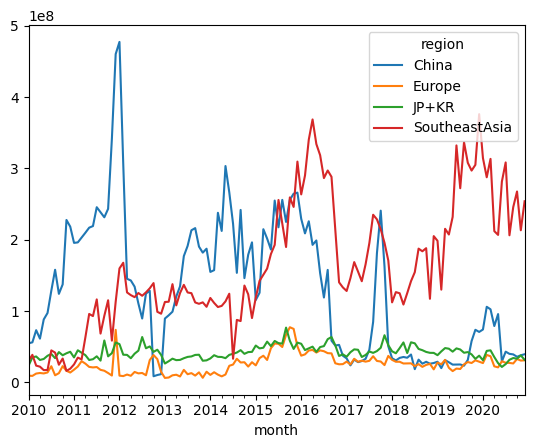

In [52]:
df.set_index('month').plot()
plt.show()

In [53]:
total_exports = df.set_index('month').sum().sort_values(ascending=False)
top_3_countries = total_exports.head(3).index.tolist()
print(top_3_countries)

['SoutheastAsia', 'China', 'JP+KR']


## LOTKA VOLTERRA BASICO

In [54]:
df = df.set_index('month')

In [55]:
# Fill missing values (optional)
df = df.fillna(method='ffill').fillna(method='bfill')

# Normalize (optional but helps with scaling)
df = df / df.max()

C:\Users\Leonardo\AppData\Local\Temp\ipykernel_22196\2618631790.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


In [56]:
df

region,China,Europe,JP+KR,SoutheastAsia
month,,,,
2010-01-01,0.114907,0.122269,0.306883,0.081465
2010-02-01,0.117696,0.118064,0.456854,0.102791
2010-03-01,0.153372,0.160323,0.473063,0.062514
2010-04-01,0.128563,0.170660,0.409454,0.058692
2010-05-01,0.184947,0.162677,0.427668,0.045814
...,...,...,...,...
2020-08-01,0.083881,0.353148,0.412675,0.548504
2020-09-01,0.082283,0.343355,0.445020,0.653634
2020-10-01,0.075165,0.424261,0.432254,0.711664


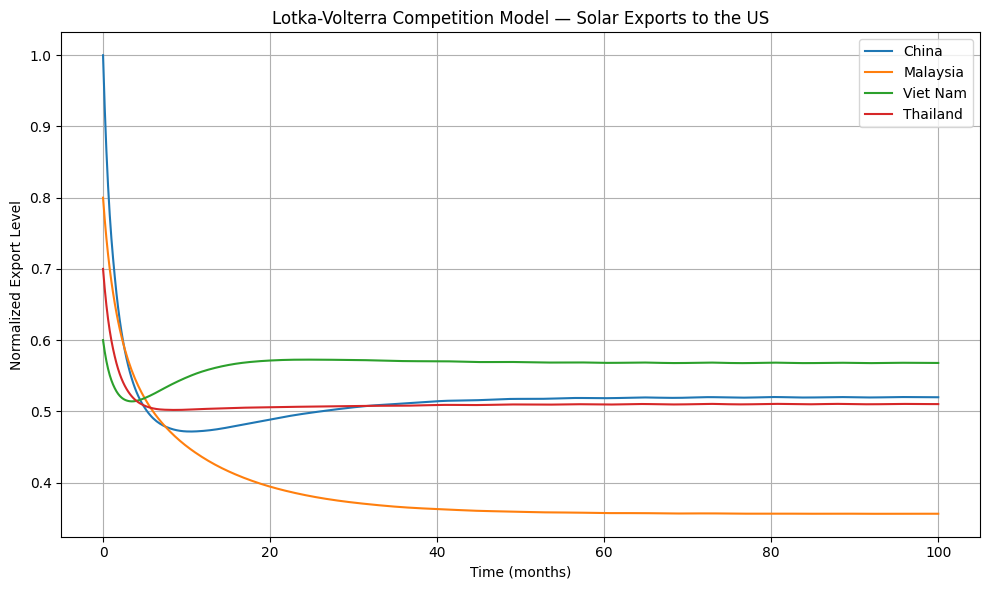

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def lotka_volterra_4_explicit(t, X, r1, r2, r3, r4,
                               a11, a12, a13, a14,
                               a21, a22, a23, a24,
                               a31, a32, a33, a34,
                               a41, a42, a43, a44):
    x1, x2, x3, x4 = X

    dx1dt = r1 * x1 * (1 - a11 * x1 - a12 * x2 - a13 * x3 - a14 * x4)
    dx2dt = r2 * x2 * (1 - a21 * x1 - a22 * x2 - a23 * x3 - a24 * x4)
    dx3dt = r3 * x3 * (1 - a31 * x1 - a32 * x2 - a33 * x3 - a34 * x4)
    dx4dt = r4 * x4 * (1 - a41 * x1 - a42 * x2 - a43 * x3 - a44 * x4)

    return [dx1dt, dx2dt, dx3dt, dx4dt]

# Parameters
params = {
    'r1': 0.5, 'r2': 0.3, 'r3': 0.4, 'r4': 0.45,
    'a11': 1.0, 'a12': 0.6, 'a13': 0.2, 'a14': 0.3,
    'a21': 0.3, 'a22': 1.0, 'a23': 0.5, 'a24': 0.4,
    'a31': 0.4, 'a32': 0.2, 'a33': 1.0, 'a34': 0.3,
    'a41': 0.3, 'a42': 0.3, 'a43': 0.4, 'a44': 1.0
}

# Initial conditions
X0 = [1.0, 0.8, 0.6, 0.7]  # China, Malaysia, Viet Nam, new exporter (e.g., Thailand)

# Time span and evaluation points
t_span = (0, 100)
t_eval = np.linspace(*t_span, 500)

# Solve the system
sol = solve_ivp(
    fun=lambda t, X: lotka_volterra_4_explicit(t, X, **params),
    t_span=t_span,
    y0=X0,
    t_eval=t_eval,
    method='RK45'
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='China')
plt.plot(sol.t, sol.y[1], label='Malaysia')
plt.plot(sol.t, sol.y[2], label='Viet Nam')
plt.plot(sol.t, sol.y[3], label='Thailand')  # Replace with desired country
plt.title('Lotka-Volterra Competition Model — Solar Exports to the US')
plt.xlabel('Time (months)')
plt.ylabel('Normalized Export Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [58]:
df

region,China,Europe,JP+KR,SoutheastAsia
month,,,,
2010-01-01,0.114907,0.122269,0.306883,0.081465
2010-02-01,0.117696,0.118064,0.456854,0.102791
2010-03-01,0.153372,0.160323,0.473063,0.062514
2010-04-01,0.128563,0.170660,0.409454,0.058692
2010-05-01,0.184947,0.162677,0.427668,0.045814
...,...,...,...,...
2020-08-01,0.083881,0.353148,0.412675,0.548504
2020-09-01,0.082283,0.343355,0.445020,0.653634
2020-10-01,0.075165,0.424261,0.432254,0.711664


## CALIBRATION

In [59]:
from scipy.optimize import least_squares

china_data = df['China']
europe_data = df['Europe']
jp_kr_data = df['JP+KR']
se_data = df['SoutheastAsia']

# Stack data for comparison
data = np.vstack([china_data, europe_data, jp_kr_data, se_data])  # shape (3, T)
t_data = np.linspace(0, len(china_data)-1, len(china_data))  # e.g. months

In [60]:
def residuals(params, X0, t_data, data):
    # Unpack parameters
    r1, r2, r3, r4 = params[:4]
    a11, a12, a13, a14 = params[4:8]
    a21, a22, a23, a24 = params[8:12]
    a31, a32, a33, a34 = params[12:16]
    a41, a42, a43, a44 = params[16:]

    # Solve the system
    sol = solve_ivp(
        fun=lambda t, X: lotka_volterra_4_explicit(t, X,
                                                   r1, r2, r3, r4,
                                                   a11, a12, a13, a14,
                                                   a21, a22, a23, a24,
                                                   a31, a32, a33, a34,
                                                   a41, a42, a43, a44),
        t_span=(t_data[0], t_data[-1]),
        y0=X0,
        t_eval=t_data,
        method='RK45'
    )

    # Check for integration failure
    if sol.y.shape[1] != len(t_data):
        return np.ones(data.size) * 1e6

    # Return flattened residuals
    return (sol.y - data).ravel()


In [61]:
from scipy.optimize import least_squares

# Initial guess for 4 species: r1–r4, a11–a44 (row-wise)
initial_guess = [
    0.5, 0.3, 0.4, 0.35,        # r1, r2, r3, r4
    1.0, 0.6, 0.2, 0.1,         # a11, a12, a13, a14
    0.3, 1.0, 0.5, 0.2,         # a21, a22, a23, a24
    0.4, 0.2, 1.0, 0.3,         # a31, a32, a33, a34
    0.2, 0.4, 0.3, 1.0          # a41, a42, a43, a44
]

# Initial export levels from your data (must be shape (4,))
X0 = data[:, 0]

# Bounds (e.g., positive parameters only, up to 10)
lower_bounds = [0] * 20
upper_bounds = [10] * 20

# Fit the model to data
result = least_squares(
    residuals,
    initial_guess,
    args=(X0, t_data, data),
    bounds=(lower_bounds, upper_bounds)
)

# Extract fitted parameters
fitted_params = result.x


In [62]:
fitted_params

array([3.62576596e-01, 5.68250095e-02, 1.09082563e-01, 2.30806827e-01,
       7.94255861e-01, 1.90170398e-01, 7.70516607e-01, 6.72182410e-01,
       2.40660424e-02, 8.66048326e-02, 4.34367258e-01, 1.39581655e+00,
       1.29381171e+00, 3.54868378e-05, 2.90831251e-04, 1.43870714e+00,
       1.04606468e+00, 8.13438814e-02, 3.80520910e-01, 9.30465159e-01])

<Axes: xlabel='month'>

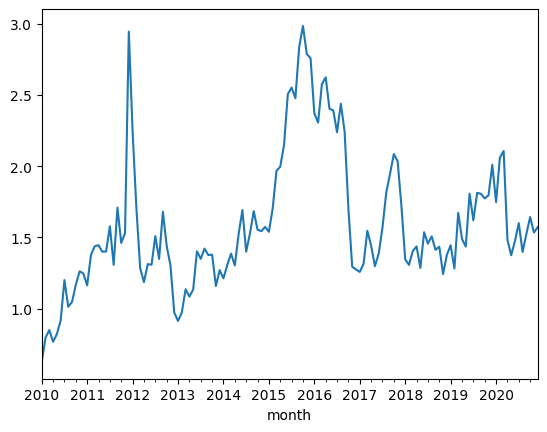

In [63]:
df.sum(axis = 1).plot()

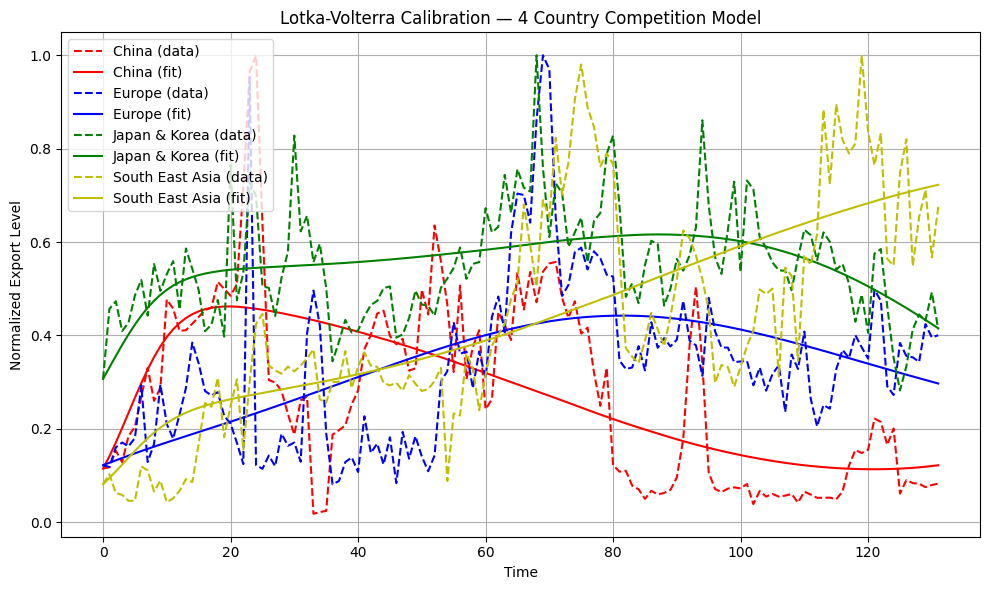

In [64]:
# Solve the system using the fitted parameters
sol = solve_ivp(
    fun=lambda t, X: lotka_volterra_4_explicit(t, X, *fitted_params),
    t_span=(t_data[0], t_data[-1]),
    y0=X0,
    t_eval=t_data
)

# Plot results: data vs. model for all 4 countries
plt.figure(figsize=(10, 6))
colors = ['r', 'b', 'g', 'y']
labels = ['China', 'Europe', 'Japan & Korea', 'South East Asia']  # update names if needed

for i in range(4):
    plt.plot(t_data, data[i], f'{colors[i]}--', label=f'{labels[i]} (data)')
    plt.plot(t_data, sol.y[i], f'{colors[i]}-', label=f'{labels[i]} (fit)')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration — 4 Country Competition Model')
plt.grid(True)
plt.tight_layout()
plt.show()
